In [1]:
%reset
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from functions import loader, splt, fitter, stats
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from uncertainties import *
from uncertainties import unumpy as unp

savedir = "D05/"

In [3]:
## Choose if is better with dedicated data...

all_data = loader.load_data( "../CloudVenetoAnalysisBis/20220611UngaussianityBySizeHighRes*/**/" )
data = all_data
len( data )

## Or with all data

# all_data = loader.load_data()
# data = loader.remove_duplicates( all_data,
#     lambda d: ( d['dep_polymers'], d['side'], d['defects_frac'], d['gamma'] ),
#     lambda d: d['runned_replicas']
# )
# data = data[ np.vectorize( lambda d: ( d['gamma'] == 0.4 ) and ( d['defects_frac'] == 0.2 ) )( data ) ]
# len( data )

21

In [4]:
for d in data:
    # x, y = fitter.rebin_width( d['h_x'], d['h'], 0.0002 )
    x, y = fitter.rebin_n( d['h_x'], d['h'], 50 )
    d['fits'] = fitter.entropyc_fits( d['xs'], x )
    d['skew'] = skew( d['chunks'], bias=True )
    d['skew_u'] = stats.compute_in_decades( d['chunks'], lambda c: skew( c, bias=True ) )
    d['G'] = stats.G( d['chunks'] )
    d['G_u'] = stats.compute_in_decades( d['chunks'], lambda c: stats.G( c ) )
    d['npskew'] = ( np.mean( d['chunks'] ) - np.median( d['chunks'] ) ) / np.std( d['chunks'], ddof = 1 )
    d['npskew_u'] = stats.compute_in_decades( d['chunks'], lambda c: ( np.mean( c ) - np.median( c ) ) / np.std( c, ddof = 1 ) )
    d['Z&S'] = np.sqrt( 2 * len( d['chunks'] ) ) * ( np.mean( d['chunks'] ) - np.median( d['chunks'] ) ) / np.std( d['chunks'], ddof = 1 )
    d['kurt'] = kurtosis( d['chunks'] )

len( data )

d:\Dropbox\Gali\Tesi\RSA_problem\Analysis\functions\fitter.py:108: RuntimeWarning: overflow encountered in exp
  return np.log( pref ) - a * ( b * ( x - u ) + np.exp( - b * ( x - u ) ) )
c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


21

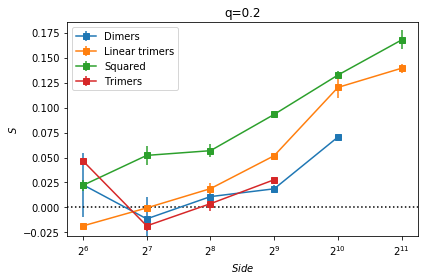

In [5]:
filtered_data = data
max = np.max( [ d['npskew'] for d in filtered_data ] )
min = np.min( [ d['npskew'] for d in filtered_data ] )

splt.oneitem_iterate_errorbar(
    len( filtered_data ),
    lambda d: filtered_data[d]['defects_frac'],
    lambda d: filtered_data[d]['dep_polymers'],
    lambda d: filtered_data[d]['side'],
    lambda d: [
        filtered_data[d]['npskew_u'],
    ],
    lambda it, l: [
        { 'label': fr"{l}", 'ls': '-', 'marker': 's'  }
    ],
    lambda it: (
        plt.title( fr"q={it}" ),
        plt.ylim( np.min( [min * 1.1, min * 0.9] ), max * 1.1 ),
        plt.xscale( 'log', basex = 2 ),
        # plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"$Side$" ),
        splt.hline( 0 ),
        plt.ylabel( fr"$S$" )
    )
)

plt.tight_layout()
plt.savefig( savedir + "nonparametric_skewness_ofL_witherrors.pdf" )
plt.savefig( savedir + "nonparametric_skewness_ofL_witherrors.png" )

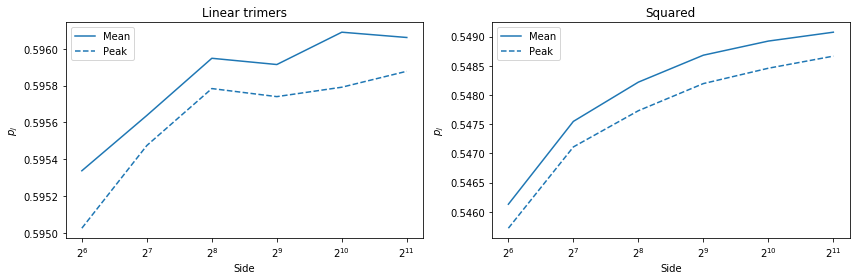

In [6]:
filtered_data = data[ np.vectorize( lambda d: ( d['dep_polymers'] == 'Squared' ) or ( d['dep_polymers'] == 'Linear trimers' ) )( data ) ]

def get_GG_peak( d ):
    mu = filtered_data[d]['fits']['GG']['pars'][0]
    s  = filtered_data[d]['fits']['GG']['pars'][1]
    xs = np.linspace( mu - 3 * s, mu + 3 * s, 10000 )
    ys = fitter.GG( xs, 1, *filtered_data[d]['fits']['GG']['pars'] )
    return xs[ np.argmax( ys ) ]

splt.oneitem_iterate(
    len( filtered_data ),
    lambda d: filtered_data[d]['dep_polymers'],
    lambda d: 1,
    lambda d: filtered_data[d]['side'],
    lambda d: [
        filtered_data[d]['fits']['GG']['pars'][0],
        get_GG_peak( d )
    ],
    lambda it, l: [
        { 'label': fr"Mean", 'ls': '-', 'marker': ''  },
        { 'label': fr"Peak", 'ls': '--', 'marker': '' }
    ],
    lambda it: (
        plt.title( f"{it}" ),
        plt.xscale( 'log', basex = 2 ),
        # plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"Side" ),
        plt.ylabel( "$p_j$" )
    )
)

plt.tight_layout()
plt.savefig( savedir + "mean_and_peak_position_ofL_witherrors.pdf" )
plt.savefig( savedir + "mean_and_peak_position_ofL_witherrors.png" )

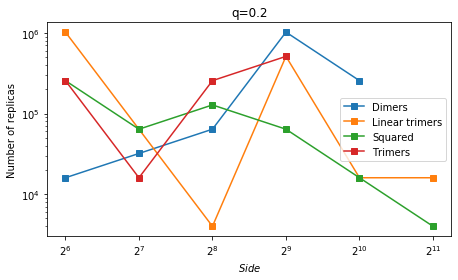

In [7]:
filtered_data = data

splt.oneitem_iterate(
    len( filtered_data ),
    lambda d: filtered_data[d]['defects_frac'],
    lambda d: filtered_data[d]['dep_polymers'],
    lambda d: filtered_data[d]['side'],
    lambda d: [
        len( filtered_data[d]['chunks'] ),
    ],
    lambda it, l: [
        { 'label': fr"{l}", 'ls': '-', 'marker': 's'  }
    ],
    lambda it: (
        plt.title( fr"q={it}" ),
        plt.xscale( 'log', basex = 2 ),
        plt.yscale( 'log', basey = 10 ),
        plt.xlabel( fr"$Side$" ),
        splt.hline( 0 ),
        plt.ylabel( fr"Number of replicas" )
    )
)

plt.tight_layout()